# Stocks demo pipeline

## steps
* [Run notebook ingest_stocks](01_ingest_news.ipynb)
* [Run notebook ingest_news](02_ingest_stocks.ipynb)
* [Create feature vector](#Create-feature-vector)
* [Set up the project](#Set-up-the-project)
* [Write and save workflow](#Write-and-save-workflow)
* [Run the workflow](#Run-the-workflow)

In [1]:
# !/User/align_mlrun.sh

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-09-04 15:17:31,648 [info] loaded project stocks from MLRun DB


# Create feature vector

In [3]:
# Define the list of features we will be using
features = ['stocks.*',
            'news.sentiment',
            ]

# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the feature vector name for future reference
fv_name = 'stocks'

# Define the feature vector using our Feature Store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          description='stocks information')

# Save the feature vector in the Feature Store
transactions_fv.save()

In [4]:
# Get offline feature vector as dataframe and save the dataset to parquet
import datetime
start_time = datetime.datetime.now()-datetime.timedelta(59)
end_time = end_time = datetime.datetime.now()-datetime.timedelta(0)
fv_data = fstore.get_offline_features(fv_name,start_time=start_time,end_time=end_time, entity_timestamp_column = 'Datetime')
fv_data.to_dataframe().head()

,Open,High,Low,Close,Volume,ticker2onehot_A,ticker2onehot_AAL,ticker2onehot_AAP,ticker2onehot_AAPL,ticker2onehot_ABBV,ticker2onehot_ABC,ticker2onehot_ABMD,ticker2onehot_ABT,ticker2onehot_ACN,ticker2onehot_ADBE,sentiment
0,13.985000,14.110000,13.985000,14.040600,0,0,1,0,0,0,0,0,0,0,0,NaN
1,121.900002,122.345001,121.900002,122.139999,0,1,0,0,0,0,0,0,0,0,0,NaN
2,108.779999,109.080002,108.690002,109.019997,0,0,0,0,0,0,0,0,1,0,0,NaN
3,140.710007,141.210007,140.580002,141.210007,0,0,0,0,0,0,1,0,0,0,0,NaN
4,150.871002,151.559998,150.580002,151.410004,0,0,0,0,0,1,0,0,0,0,0,NaN


## Set up the project

In [5]:
import os

# getting our model training function
project.set_function(os.path.join(os.getcwd(),'src','train_stocks.py'),
                     name='train_stocks', kind='job', image='mlrun/ml-models')


project.set_function(os.path.join(os.getcwd(),'src','serving_stocks.py'),
                     name='serving_stocks', kind='serving', image='mlrun/ml-models')

## Write and save workflow

In [6]:
%%writefile src/workflow.py
import mlrun
from kfp import dsl

@dsl.pipeline(
    name="Stocks Prediction Pipeline",
    description="predicting stock prices using yahoo api with sentiment analysis"
)

def kfpipeline(vector_name:str,
               seq_size:int = 5,
               batch_size:int = 1,
               hidden_dim:int = 2,
               n_layers:int = 1,
               epochs:int = 3,
               start_time:int = 59,
               end_time:int = 0,
               model_filepath = './'
               ):
    
    project = mlrun.get_current_project()
    
    train_stocks = project.get_function('train_stocks').apply(mlrun.auto_mount())

    train_stocks_run = mlrun.run_function(name='train_stocks',
                                          function='train_stocks',
                                          handler='handler',
                                          params={'context':context,
                                                  'hidden_dim':hidden_dim,
                                                  'n_layers':n_layers,
                                                  'epochs':epochs, 
                                                  'vector_name':vector_name,
                                                  'seq_size':seq_size,
                                                  'start_time':start_time,
                                                  'end_time':end_time,
                                                  'batch_size':batch_size,
                                                  'model_filepath':model_filepath},
                                          outputs=["model"])
    
    
    # deploying serving function
    serving_function = project.get_function("serving_stocks")
    # Mount it:
    serving_function.apply(mlrun.mount_v3io())
    # Set the topology and get the graph object:
    graph = serving_function.set_topology("flow", engine="async")
    # Build the serving graph:
    graph.to(handler='preprocess', name='reading_data')\
         .to(class_name="StocksModel", model_name='stocks_model', model_path=str(train_stocks_run.outputs['model']))\
         .to(handler='postprocess',name='postprocess').respond()
         
    
    # Set the desired requirements:
    serving_function.with_requirements(requirements=['yfinance','yahoo_fin'])
    # Deploy the serving function:
    mlrun.deploy_function("serving_stocks")

Overwriting src/workflow.py


In [7]:
# Register the workflow file:
workflow_name = "stocks_workflow"
project.set_workflow(workflow_name, "workflow.py")

# Save the project:
project.save()

## Run the workflow

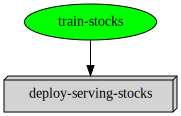

In [ ]:
project.run(name=workflow_name,
            arguments={
                "vector_name":"stocks",
                "seq_size": 5,
                "batch_size": 1,
                "hidden_dim": 2,
                "n_layers": 1,
                "epochs": 5,
                "start_time":59,
                "end_time":0,
                "model_filepath":os.path.join(os.getcwd(),'src')},
            watch=True)